In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Read this First

#### Remember that `tab` is is useful for autocompletion.

#### Remember that `shift + tab` is useful for rapidly obtaining usage + documentation.

###**Optical Flow**

**Throughout the class, we've been looking at many ways to analyze and extract spatial information from images. Now we'll briefly talk about how we can use the temporal information inherent in series of images to learn more about the content of the images.**

**One way of getting information temporally is through optical flow, which is the apparent motion of brightness patterns in the image. Ideally, optical flow would be the same as the motion field, which is a representation of real world 3D motion. So by finding the optical flow field, we can hopefully observe real world motion behaviour of objects that are present in the image.**

**Let's first import some things.**

In [2]:
from time import sleep

import numpy as np
from scipy import signal
from scipy.ndimage.filters import gaussian_filter

import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
#from google.colab.patches import cv2_imshow
#import cv2_imshow

**Read in the gif that is part of the repo, of three cars moving. We'll display it as a series of imshows with a small delay in between - you might see some flashing as the images change from one frame to another (I couldn't really figure out a nice way to display gifs in google colab).**

In [3]:
gif = cv2.VideoCapture('taxi.gif')

for i in range(int(gif.get(cv2.CAP_PROP_FRAME_COUNT))):
  ret, frame = gif.read()
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  clear_output(wait=True)
  cv2.imshow('gif',frame_gray)
  sleep(0.4)

**The object produced by the VideoCapture function isn't really nice to deal with, as we can't index through it nicely, and we want to work with grayscale images as well. Hence, below, find the number of frames, height, and width of the image sequence.**

**Then create a 3D matrix called "frames" of size num_frames $\times$ height $\times$ width, that stores the grayscaled frames of the original gif. To check that this works, display the first frame using plt.imshow. (Don't worry if you see that it doesn't start at (0, 0) for the plot)**

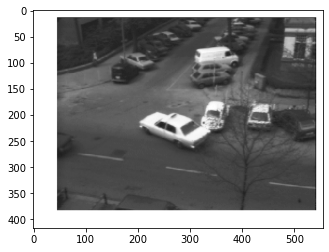

In [5]:
gif = cv2.VideoCapture('taxi.gif')

frames = []
while(gif.isOpened()):
    ret, frame = gif.read() # read in BGR, not RGB !!!!
    if ret==True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    else:
        break
cv2.destroyAllWindows() 
    
gif = np.array(frames)
num_frames = len(gif)
height = gif.shape[1]
width = gif.shape[2]
plt.imshow(frames[0], cmap="gray")

**In lecture, we saw that to get the optical flow, we assumed brightness contancy, small motion, and spatial coherence. This allows us to use gradients within a frame and between frames to determine motion of pixels from one frame to another.**

**Fill out the function below that takes two frames, im1 and im2, and computes the $\sum I_xI_x$, $\sum I_xI_y$, and $\sum I_yI_y$ terms for the second frame, and $\sum I_xI_t$ and $\sum I_yI_t$ terms between the two frames.**

**For $I_x$ and $I_y$ use np.gradient of the second frame, and $I_t$ should be the pixel-wise difference between the two frames. $I_xIx$, $I_yI_y$, $I_xI_y$, $I_xI_t$, and $I_yI_t$ are computed with pixel wise multiplication as usual.**

**To compute the $\sum$, at every pixel sum up the relevant terms in a gaussian window around that pixel, using scipy.ndimage.gaussian_filter with sigma=3 (This is like what we did with the Harris Corner Detector in Week 4 notebook.**

In [6]:
from scipy.ndimage.filters import gaussian_filter
def getGradients(im1, im2):
    """ Computes the gradients that are needed to find optical flow between im2 and im1.
      Args:
        im1: First frame of size [height, width]
        im2: Second frame of size [height, width]
      Returns:
        i_xx_sum: 2D matrix of size [height, width] that contains sum of I_xI_x values in a gaussian window at each pixel
        i_xy_sum: 2D matrix of size [height, width] that contains sum of I_xI_y values in a gaussian window at each pixel
        i_yy_sum: 2D matrix of size [height, width] that contains sum of I_yI_y values in a gaussian window at each pixel
        i_xt_sum: 2D matrix of size [height, width] that contains sum of I_xI_t values in a gaussian window at each pixel
        i_yt_sum: 2D matrix of size [height, width] that contains sum of I_yI_t values in a gaussian window at each pixel
    """
    i_y, i_x = np.gradient(im2)
    i_t = im2 - im1
    
    i_xx = i_x * i_x
    i_xy = i_x * i_y
    i_yy = i_y * i_y
    i_xt = i_x * i_t
    i_yt = i_y * i_t
    i_xx_sum = gaussian_filter(i_xx, sigma=3)
    i_xy_sum = gaussian_filter(i_xy, sigma=3)
    i_yy_sum = gaussian_filter(i_yy, sigma=3)
    i_xt_sum = gaussian_filter(i_xt, sigma=3)
    i_yt_sum = gaussian_filter(i_yt, sigma=3)

    return i_xx_sum, i_xy_sum, i_yy_sum, i_xt_sum, i_yt_sum

**Why do we sum the gradient terms in a window around each pixel? What assumption are we making here that allows us to do this?**

pixel's neighborhood has similar motion (u,v)

**Using those gradients, we can create a least squares equation that is similar to the Harris Corner Detector. In the function below, fill out the missing lines to finish the function to find optical flow.**

**Note that when we solve for $[u, v]^T$, we don't use np.linalg.lstsqr or some other method - we can solve for it directly, as from slide 39 we see $d=(A^TA)^{-1}(-A^Tb)$, and we check beforehand whether $A^TA$ is invertible.**

In [7]:
def optical_flow(im1, im2, stride):
    """ Computes the optical flow between frames im2 and im1.
      Args:
        im1: First frame of size [height, width]
        im2: Second frame of size [height, width]
        stride: Determines how dense you want the optical flow field to be
      Returns:
        u: x value of optical flow vector of every pixel
        v: y value of optical flow vector of every pixel
    """

    # Calls our previous function to get the image gradients
    height, width = im1.shape
    i_xx_sum, i_xy_sum, i_yy_sum, i_xt_sum, i_yt_sum = getGradients(im1, im2)

    # Create containers for storing the u, v components of optical flow vector for each pixel
    u = np.zeros(im1.shape)
    v = np.zeros(im2.shape)

    # Loop through every stride pixels
    for i in range(0, height, stride):
        for j in range(0, width, stride):
            ATA = np.array( [ [i_xx_sum[i,j] ,i_xy_sum[i,j] ] , [i_xy_sum[i,j] , i_yy_sum[i,j] ] ] )
            ATb = np.array( [ -1.0 * i_xt_sum[i,j] , -1.0 * i_xy_sum[i,j] ] )
            ATb = ATb.reshape(2,1)
        # Find the ATA matrix for this pixel (see slide 39)
        ## TODO
        
        # Find the ATb matrix for this pixel (see slide 39)
        ## TODO

        # Compute the determinant of the ATA matrix, and if it zero, we move on to the next pixel
        ## TODO
            if(np.abs( np.linalg.det(ATA)) > 1e-4):
                t = np.linalg.inv(ATA) @ ATb
        # Directly solve for the u, v terms
        ## TODO
                u[i, j] = t[0]
                v[i, j] = t[1]
                #print(u[i,j], v[i,j])

    return u, v

**We can now test it out by running our gif that we have stored in frames below. Call optical_flow(frames[i-1], frames[i], 1) for each of our frames, and store the resulting u, v fields in u_list and v_list. If it's taking too long, you can change the stride to be 2 instead of 1. (It takes around 90 seconds for stride=1 and around 23 seconds for stride=2 for me)**

In [8]:
u_list = np.zeros((num_frames, height, width))
v_list = np.zeros((num_frames, height, width))
for i in range(num_frames):
#for i in range(1):
    u , v = optical_flow( gif[i] , gif[i+1] , stride = 1)
    print(i)
    u_list[i] = u
    v_list[i] = v
    #print(np.maximum(u))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


IndexError: index 41 is out of bounds for axis 0 with size 41

**Let's visualize the optical flow field gradient. Below, for every frame, compute the optical flow gradient $u^2+v^2$ at every pixel and use plt.imshow with cmap='hot' to display this.** 

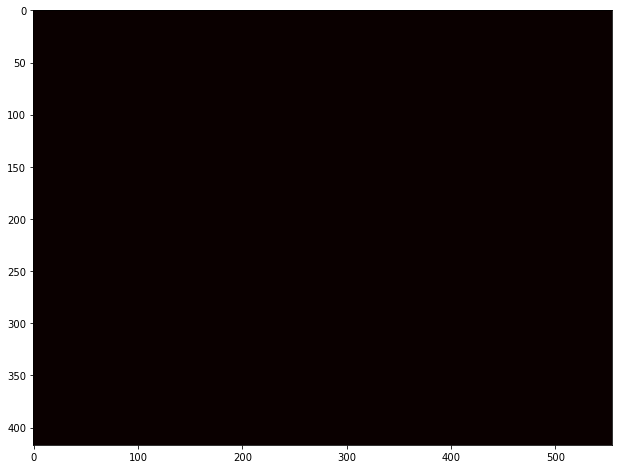

In [9]:
for i in range(num_frames):
    clear_output(wait=True)
    img = u_list[i,:,:]**2 + v_list[i,:,:]**2
    # Display the image here
    ## TODO
    plt.figure(figsize=(12, 8))
    plt.imshow(img,cmap='hot')
    plt.show()
    sleep(0.3)

**You should be seeing three car-shaped areas that move just like how the cars move in the original gif.**

**Finally, we can visualize the optical vector field directly as well, using plt.quiver.**

**Similar to what was done above, plot and display the optical vector field for each frame in a sequence. Sample the pixels so that you only display the optical field vector for every 10th pixel (doesn't have to be exactly 10; just make sure that it's not too crowded or too sparse).**

**Since plt.quiver is a plot, you might want to invert the y axis using plt.gca().inverse_yaxis() so it's an image.**

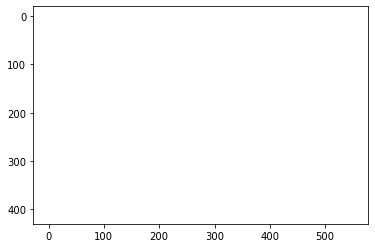

In [11]:
I = np.array(list(range(0,height,10)))
J = np.array(list(range(0,width,10)))

X,Y=np.meshgrid(J,I)

for frame in range(num_frames):
    clear_output(wait=True)

    U = []
    V = []
    for i in range( len(I) ):
        for j in range( len(J) ):
        
            U.append( u_list[frame , Y[i,j] , X[i,j]] )
            V.append( v_list[frame , Y[i,j] , X[i,j]] )
            
    plt.quiver(X,Y,np.array(U).reshape(X.shape), np.array(V).reshape(X.shape))
    ax = plt.gca()
    ax.invert_yaxis()
    plt.show()

    sleep(0.3)

